# Train a classifier for shell company roles

## set up environment

In [1]:
import json
import pathlib
import typing

from icecream import ic
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import export_text, plot_tree
import joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import watermark

In [2]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2025-06-20T10:21:57.979149-07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.3.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.30)
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

joblib    : 1.5.1
watermark : 2.5.0
seaborn   : 0.13.2
matplotlib: 3.10.3
networkx  : 3.5
numpy     : 2.3.0
pandas    : 2.3.0
sklearn   : 1.7.0
json      : 2.0.9



## load graph data

In [3]:
data_path: pathlib.Path = pathlib.Path("data")

graph_file: pathlib.Path = data_path / "occrp.json"
graph: nx.DiGraph = nx.DiGraph() # placeholder

with open(graph_file, "r", encoding = "utf-8") as fp:
    graph = nx.node_link_graph(
        json.load(fp),
        edges = "edges",
    )

In [4]:
node_data: typing.List[ dict ] = [
    {
        "id": node_id,
        "name": dat["name"],
        "role": dat["role"],
        "degree": dat["degree"],
        "out_deg": dat["out_deg"],
        "balance": dat["balance"],
    }
    for node_id, dat in graph.nodes(data = True)
]

df: pd.DataFrame = pd.DataFrame.from_dict(
    node_data,
    orient = "columns",
)

df.head()

,id,name,role,degree,out_deg,balance
0,0,AZARBAYCAN METANOL KOMPANI MMC,source,1,1,-1.511916e+06
1,1,LCM ALLIANCE LLP,drain,273,1,8.479847e+08
2,2,SKN ELECTRICAL SERVICES LIMITEDACCO,source,1,1,-1.100632e+05
3,3,METASTAR INVEST LLP,drain,134,2,2.819085e+08
4,4,INMAXO CAPITAL CORP.,source,1,1,-4.152311e+05


## prep data

In [5]:
ord_enc: OrdinalEncoder = OrdinalEncoder()

df["label"] = ord_enc.fit_transform(df[["role"]])
df_iv: pd.DataFrame = df.drop([ "id", "name", "role", "label" ], axis = 1)

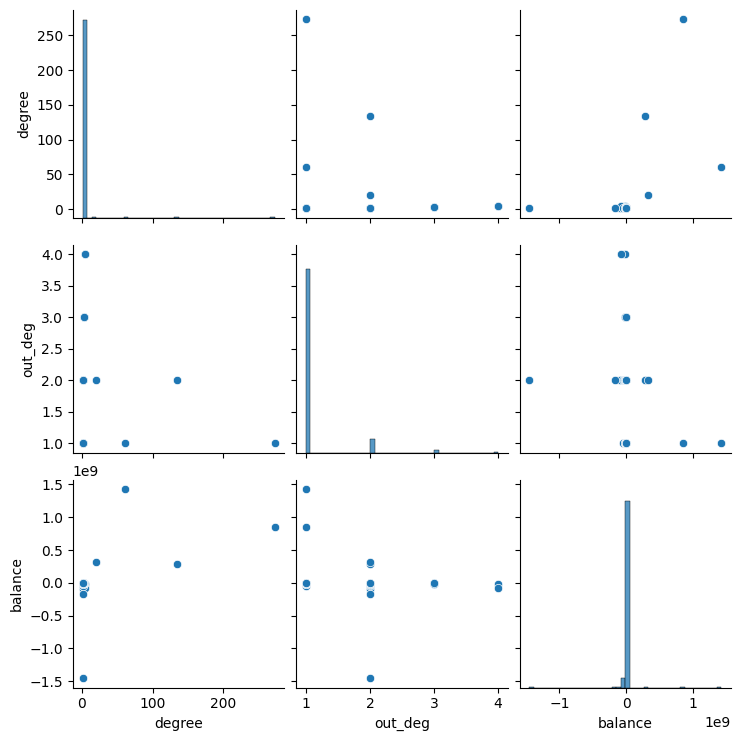

In [6]:
sns.pairplot(df_iv);

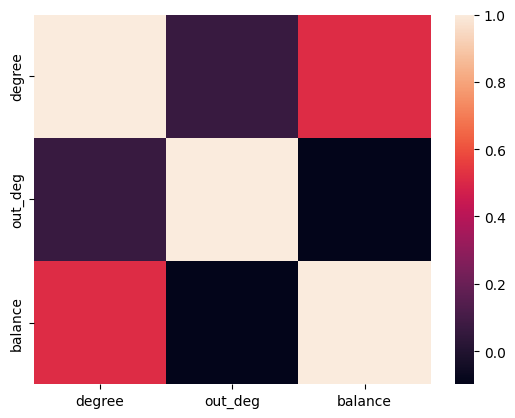

In [7]:
sns.heatmap(
    df_iv.corr(),
    xticklabels = df_iv.columns,
    yticklabels = df_iv.columns,
);

In [8]:
np.percentile(
    df["balance"],
    [ 1, 10, 50, 75, 90 ],
)

array([-4.62920794e+07, -8.06557036e+06, -4.01230000e+05, -5.49000000e+04,
       -1.10629200e+04])

In [9]:
x = df_iv
y = df["label"]

training, testing, training_labels, testing_labels = train_test_split(
    x,
    y,
    test_size = .1,
)

normalize the data

In [10]:
scaler: StandardScaler = StandardScaler()

normed_train_data = pd.DataFrame(scaler.fit_transform(training), columns = x.columns)
normed_test_data = pd.DataFrame(scaler.fit_transform(testing), columns = x.columns)

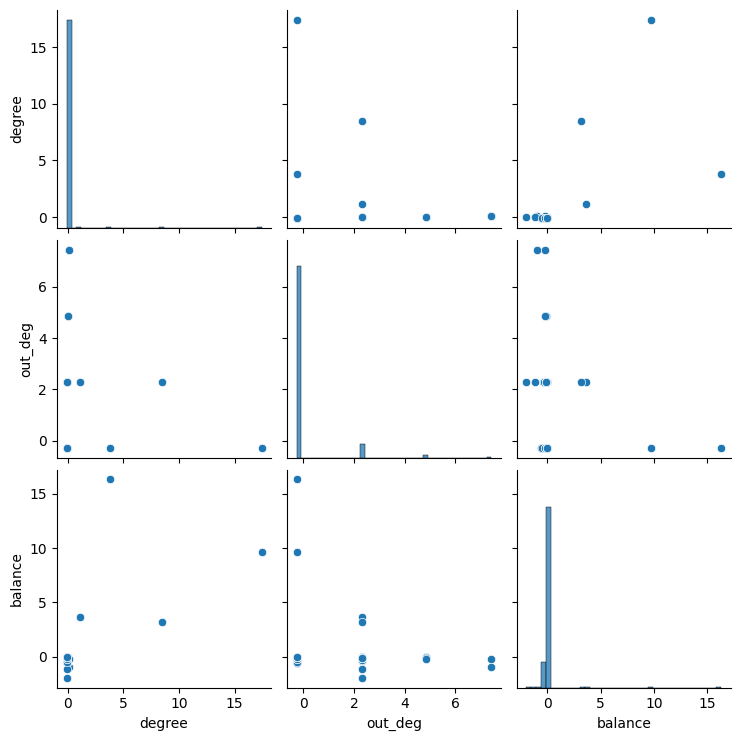

In [11]:
sns.pairplot(normed_train_data);

In [12]:
clf: RandomForestClassifier = RandomForestClassifier(
    random_state = 0,
)

clf.fit(training, training_labels)
preds = clf.predict(testing)

ic(clf.score(training, training_labels))
ic(clf.score(testing, testing_labels))

ic| clf.score(training, training_labels): 1.0
ic| clf.score(testing, testing_labels): 1.0


1.0

In [13]:
confusion_matrix(testing_labels, preds, labels = [1, 2, 3])

array([[ 3,  0,  0],
       [ 0, 41,  0],
       [ 0,  0,  0]])

In [14]:
pd.DataFrame(
    clf.feature_importances_,
    index = training.columns,
).sort_values(by = 0, ascending = False)

,0
out_deg,0.467255
degree,0.390196
balance,0.142549


## train classifier

since the classes are so highly imbalanced, let's redo training a classifier with the full dataset

In [15]:
df_norm: pd.DataFrame = pd.DataFrame(
    scaler.fit_transform(df_iv),
    columns = df_iv.columns,
)

clf: RandomForestClassifier = RandomForestClassifier()
clf.fit(df_norm, df["label"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
pd.DataFrame(
    clf.feature_importances_,
    index = df_iv.columns,
).sort_values(by = 0, ascending = False)

,0
degree,0.467988
out_deg,0.394090
balance,0.137922


In [17]:
preds: np.ndarray = clf.predict(df_norm)

for index, row in sorted(df.iterrows(), key = lambda x: x[1]["role"]):
    print(f"{index:3}: {int(preds[index]):2} {row['role']:13} {row['name']}")

  1:  0 drain         LCM ALLIANCE LLP
  3:  0 drain         METASTAR INVEST LLP
298:  0 drain         POLUX MANAGEMENT LP
302:  0 drain         HILUX SERVICES LP
  5:  1 multi-source  MOBILA LLP
  6:  1 multi-source  LOTA SALES LLP
  7:  1 multi-source  DANSKE BANK A/S EESTI FILIAAL
  8:  1 multi-source  JETFIELD NETWORKS LIMITED
  9:  1 multi-source  MUROVA SYSTEMS LLP
 10:  1 multi-source  BONINVEST LLP
 11:  1 multi-source  DEUTDEFFXXX
 12:  1 multi-source  OVERTON SALES LLP
 14:  1 multi-source  SOVER DEVELOPMENT LLP
 17:  1 multi-source  GLOBECOM TRADE L.P
 32:  1 multi-source  JETMAX CONTRACTS LLP
 44:  1 multi-source  BSMAX LLP
 49:  1 multi-source  DOCKWOOD ALLIANCE LLP
 50:  1 multi-source  MONDOTECH LLP
 61:  1 multi-source  HEKTOR INVEST LIMITED
 66:  1 multi-source  RIVERLANE LLP
 67:  1 multi-source  WAN DE BERGER SERVICES LTD
 84:  1 multi-source  NAI NORTH AMERICAN INDUSTRIAL S.A.
107:  1 multi-source  WILLROCK UNITED LLP
119:  1 multi-source  AVROMED COMPANY LLP
120:  

serialize the trained classifier model

In [18]:
joblib.dump(
    clf,
    "rf_nodes.joblib",
    compress = 3,
);

## visualize decisions

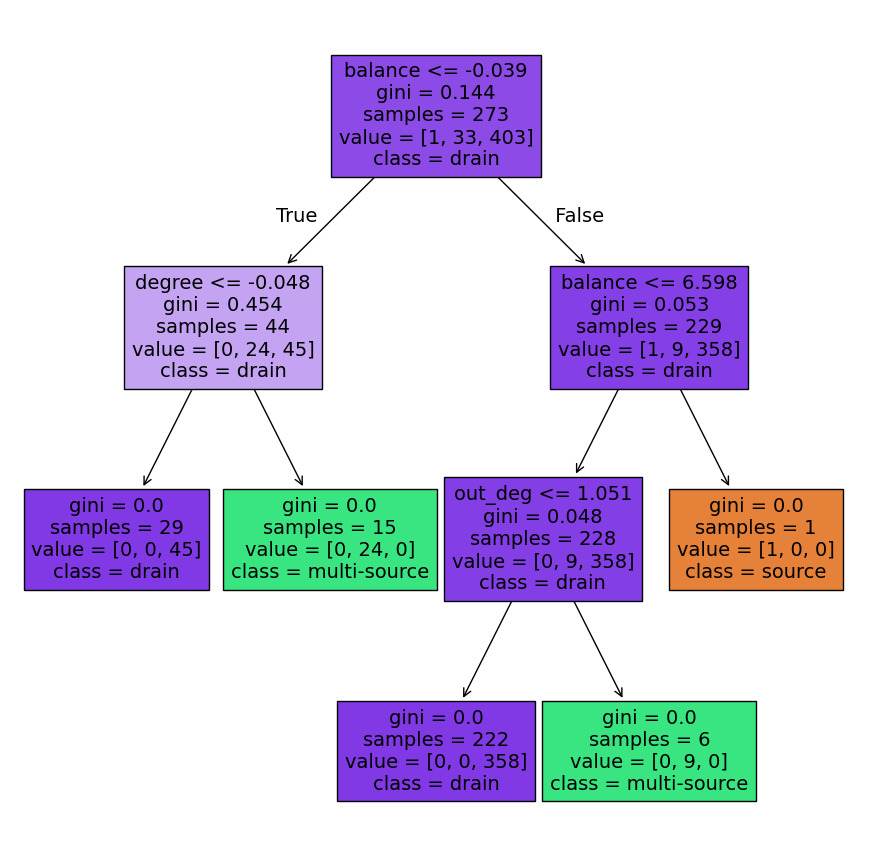

|--- balance <= -0.04
|   |--- degree <= -0.05
|   |   |--- class: 2.0
|   |--- degree >  -0.05
|   |   |--- class: 1.0
|--- balance >  -0.04
|   |--- balance <= 6.60
|   |   |--- out_deg <= 1.05
|   |   |   |--- class: 2.0
|   |   |--- out_deg >  1.05
|   |   |   |--- class: 1.0
|   |--- balance >  6.60
|   |   |--- class: 0.0



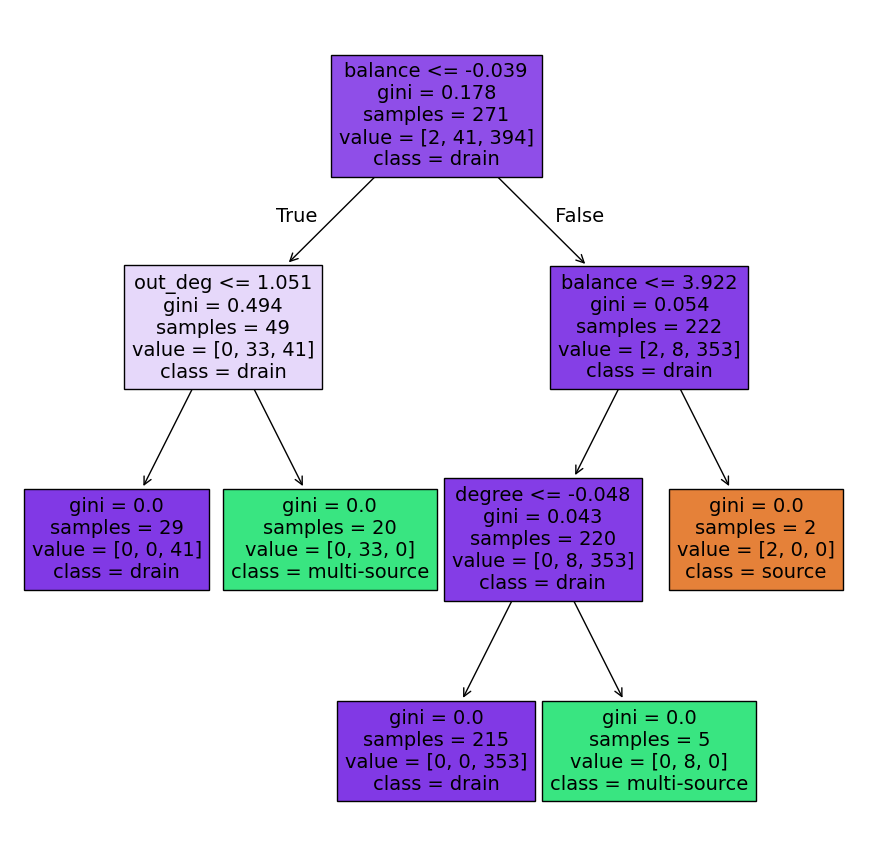

|--- balance <= -0.04
|   |--- out_deg <= 1.05
|   |   |--- class: 2.0
|   |--- out_deg >  1.05
|   |   |--- class: 1.0
|--- balance >  -0.04
|   |--- balance <= 3.92
|   |   |--- degree <= -0.05
|   |   |   |--- class: 2.0
|   |   |--- degree >  -0.05
|   |   |   |--- class: 1.0
|   |--- balance >  3.92
|   |   |--- class: 0.0

|--- balance <= -0.04
|   |--- balance <= -0.04
|   |   |--- degree <= -0.05
|   |   |   |--- class: 2.0
|   |   |--- degree >  -0.05
|   |   |   |--- class: 1.0
|   |--- balance >  -0.04
|   |   |--- balance <= -0.04
|   |   |   |--- balance <= -0.04
|   |   |   |   |--- class: 1.0
|   |   |   |--- balance >  -0.04
|   |   |   |   |--- class: 2.0
|   |   |--- balance >  -0.04
|   |   |   |--- class: 1.0
|--- balance >  -0.04
|   |--- balance <= 1.48
|   |   |--- out_deg <= 1.05
|   |   |   |--- class: 2.0
|   |   |--- out_deg >  1.05
|   |   |   |--- class: 1.0
|   |--- balance >  1.48
|   |   |--- class: 0.0

|--- balance <= -0.22
|   |--- balance <= -0.43
| 

In [19]:
def tree_viz (
    tree
    ) -> None:
    plt.figure(figsize = (11, 11))
    plt.rcParams["font.family"] = "sans-serif"

    plot_tree(
        tree,
        filled = True,
        feature_names = df_iv.columns,
        class_names = list(set(df["role"].to_list())),
    )

    plt.show()


for i, tree in enumerate(clf.estimators_):
    if i < 2:
        tree_viz(tree)

    print(
        export_text(
            tree,
            feature_names = df_iv.columns,
        )
    )